## Accessing Cloud Optimized Raster Data

With the AWS STAC API (TODO update official name) we can search and load various geospatial datasets. Below we'll work with the Sentinel-1 SLC GRD imagery, sourced from Cloud Optimized GeoTIFFs hosted on AWS. In this example, we read in radar imagery using a bounding box.

First we install any necessary packages. Please note that the following block of code only needs to be run if needed within a new workspace and that you may need to restart the kernel to use updated packages.

This installs GDAL, a C library that is not written in python, which is why we use conda to install it instead of pip.

In [21]:
!conda install -c conda-forge gdal -y -q

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
!pip install pystac_client -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.0/207.0 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.2/183.2 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.4/381.4 kB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 23.5 MB/s eta 0:00:00


We'll use pystac_client to submit our search query and rio-tiler to load and warp our Sentinel-1 rasters from the SAR view to top-down view.

### Querying the AWS STAC API with Pystac Client

First, we define the URL to our STAC API, a service that allows us to submit search queries for spatio-temporal assets (like radar raster tiles).

Next, we open this URL with pystac_client, which allow sus to use the client's search method. `client.search` accepts many different arguments to specify the search query. Since the DEM data for Sentinel-1 GRD was collected at the same time, we just need to specify the "where" with a `bbox` describing the minx, miny, maxx, maxy coordinates in lat/lon degrees.

In [2]:
import os
from pystac_client import Client
import stackstac
# making a connection to AWS STAC API
API_ROOT_URL = "https://1hfhn8bf6g.execute-api.us-west-2.amazonaws.com"
client = Client.open(API_ROOT_URL)

# our search requirements, a bounding box for San Ignacio. Belize
bbox = [-89.19605011359278, 17.028707271735962, -88.94369134663197, 17.263285211322446]
source_search = client.search(
        collections=["sentinel1-grd"], bbox=bbox
    )

# getting the metadata and links to data assets in STAC format
source_items = source_search.get_all_items()
print("Number of Sentinel-1 tiles: ", len(source_items))

Number of Sentinel-1 tiles:  348


### Loading Setninel-1 raster with rasterio and rioxarray

There are multiple options for loading STAC item assets into in-memory arrays. `rasterio` allows you to load a Cloud Optimized Geotiff directly from a URL. Sentinel-1 is a unique dataset in that each GRD comes in a SAR view projection, and needs to be warped with it's accompanying ground control points (GCPs). `rasterio` can also apply this warping!  

Below is the URL we will load.

In [3]:
source_items[0].assets['vv'].href

's3://sentinel-s1-l1c/GRD/2023/1/8/IW/DV/S1A_IW_GRDH_1SDV_20230108T000713_20230108T000738_046685_059887_3C92/measurement/iw-vv.tiff'

Because of the volume of data, you'll need to take some additional steps when reading data depending on your use case:

1. Get your compute close to the data. By using AWS Sagemaker in the eu-central-1 region, you're working in the same cloud region as the s3 bucket containing Setninel-1 imagery. To cut down on data transfer times even more, it can make sense to move data from an s3 bucket to an EC2 instance's SSD. An example workload that can benefit from this is a machine learning model training process that needs to repeatedly read lots of imagery.
2. Read less data. By resamp/ling our Sentinel-1 image to a corser resolution while reading it, we can reduce the amount of data transferred.

We will use both approaches to make a quick plot of our Sentinel-1 scene. By specifying different integer values for `overview_level`, we can access reduced resolution versions of our dataset. In this case, we'll access the data with resolution reduced by roughly a factor of 10 with an overview level of 2.

In addition to additional steps for handling large data volumes, we also need to handle the fact that data requesters need to pay for the Sentinel-1 imagery. To do this, we can use a context manager and the `rasterio.Env` function to specify that we will pay for the data transfer cost.

In [4]:
import rasterio
import rioxarray
with rasterio.Env(AWS_REQUEST_PAYER="requester"):
    with rasterio.open(source_items[0].assets['vv'].href) as src:
        with rasterio.vrt.WarpedVRT(src,
                                    **{'SRC_METHOD': 'GCP_TPS'}
                                   ) as vrt:
            da_vv = rioxarray.open_rasterio(vrt, masked=True, overview_level=2)
da_vv

<xarray.DataArray (band: 1, y: 2627, x: 3635)>
[9549145 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -90.74 -90.74 -90.74 ... -88.04 -88.04 -88.04
  * y            (y) float64 18.6 18.6 18.6 18.6 ... 16.65 16.65 16.65 16.65
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

By computing the lazy array, we materialize the values of the array in local memory. This makes sure that we only do data transfer once.

In [5]:
da_vv = da_vv.compute()

Feel free to experiment with selecting different overview levels or omitting the overview level argument to read the full native resolution. Before doing so, not that Sentinel-1 images are huge! At full resolution, a single GRD is on the order of 20000 x 20000 pixels, or almost half a billion pixels. In memory, this is two and a half gigabytes!

### Plotting Resampled Sentinel-1 imagery

And now we have our Sentinel-1 image! Let's convert it to Decibel units to improve the image color scale. Since there is only one band in this dataset, we select it and then use xarray's built in plot method `imshow` to plot the raster with geographic axis.

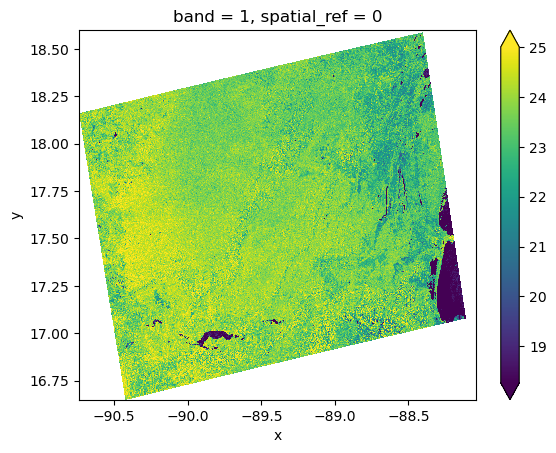

In [6]:
import numpy as np

convert_to_db = lambda x:10*np.log10(x)

convert_to_db(da_vv).sel(band=1).plot.imshow(robust=True)

The VV band alone clearly shows the presence of water. Challilo lake and portions of the Macal River flowing into it show up clearly as purple, lower VV values in the southern portion of the image.

We'll also plot the VH band. The VH band can be accessed from the dictionary of assets associated with each STAC item, just like the VV band.

In [7]:
source_items[0].assets['vh'].href

's3://sentinel-s1-l1c/GRD/2023/1/8/IW/DV/S1A_IW_GRDH_1SDV_20230108T000713_20230108T000738_046685_059887_3C92/measurement/iw-vh.tiff'

In [8]:
with rasterio.Env(AWS_REQUEST_PAYER="requester"):
    with rasterio.open(source_items[0].assets['vh'].href) as src:
        with rasterio.vrt.WarpedVRT(src,
                                    **{'SRC_METHOD': 'GCP_TPS'}
                                   ) as vrt:
            da_vh = rioxarray.open_rasterio(vrt, masked=True, overview_level=2)
da_vh

<xarray.DataArray (band: 1, y: 2627, x: 3635)>
[9549145 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -90.74 -90.74 -90.74 ... -88.04 -88.04 -88.04
  * y            (y) float64 18.6 18.6 18.6 18.6 ... 16.65 16.65 16.65 16.65
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

From our plot, we can see that the upper and minimum VH band values are lower than the VV band. "VH" refers to vertical waves transmitted, horizontal waves received and "VV" refers to vertical waves transmitted, vertical waves received. Different surfaces have different scattering properties that can affect the polarization of the transmitted signal, which Sentinel-1 can detect. To learn more about how to use the VV and VH bands in agriculture, ocean monitoring, forestry, and other earth science applications, check out the [Sentinel-1 product overview page](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-1-sar/product-overview/polarimetry) which lists resources.

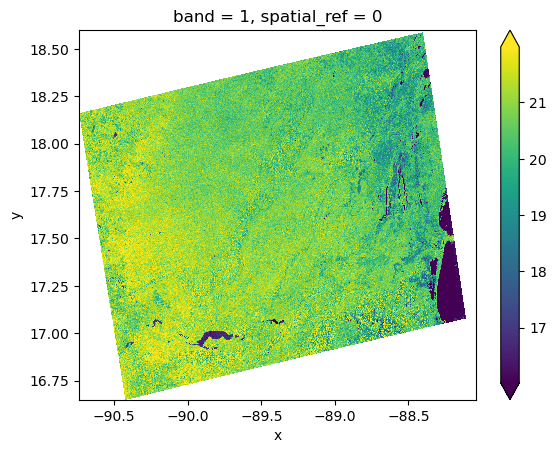

In [9]:
convert_to_db(da_vh).sel(band=1).plot.imshow(robust=True)